In [8]:
%run 00_analysis_config.ipynb

In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

<module 'visualization' from '/sdf/home/t/tomren/mathusla/mathusla_tracker_6layer/visualization.py'>

In [110]:
vertex_xyz = np.array([124.5, 5, 1])*100 # [cm]
# vertex_xyz = np.array([124.5, 5, 10])*100 # [cm]
box_lim = np.array([124.5-40, 5, 10])*100  # [cm], Set the vertex to 10m below the edge module


In [111]:
vertex=box_lim
vertex=vertex_xyz
vertex_CMS = np.array([vertex[1], -vertex[2]+85.47*100, vertex[0]])
vertex_DET = np.array([vertex[0]/100-70-49.5, vertex[1]/100, -vertex[2]/100])

In [124]:
DATA_DIR = "../data/x2mumu/"
filenames = [f"{DATA_DIR}/stat_vertex_original.root",f"{DATA_DIR}/stat_vertexmod.root"]

# DATA_DIR = "../data/x2mumu_fake/"
# filenames = [f"{DATA_DIR}/stat_vertex_original.root",f"{DATA_DIR}/stat_vertexmod.root"]

In [115]:
filename_recon = filenames[0]


# filename_recon = os.path.dirname(filename)+"/stat_seedmod.root"
tfile = root.TFile.Open(filename_recon)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
ev = event.Event(filename_recon, 0, tree_name=tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
# print("Number of events",nevents)
# print(branch_list)

res = get_km_alltracks(filename_recon, nevents=10000)
res.keys()

100%|██████████| 10000/10000 [00:14<00:00, 697.81it/s]


dict_keys(['Entry', 'ndigi', 'mask_recon_success_track', 'mask_recon_success_vertex', 'tracks_truth', 'tracks_truth_n', 'tracks_truth_nlayer', 'tracks_truth_pdgids', 'tracks_recon', 'tracks_recon_n', 'tracks_recon_error', 'tracks_ndigi', 'tracks_ndigi_false', 'tracks_purity', 'tracks_pdgids', 'tracks_chi2', 'vertices_recon', 'vertices_recon_n', 'vertices_recon_error', 'vertices_chi2'])

In [116]:
data=res
mask_vertex_recon = data["vertices_recon_n"]>=1
mask_track_recon = data["mask_recon_success_track"]
mask = mask_track_recon&mask_vertex_recon

mask_reconstructible = []
for i in data["tracks_truth_nlayer"]:
    if min(i)>=4 and len(i)>1:
        mask_reconstructible.append(True)
    else:
        mask_reconstructible.append(False)
mask_reconstructible = np.array(mask_reconstructible)
print("K_reconstructible,",sum(mask_reconstructible)/len(mask_reconstructible))

track_purity_1d = []
for i in data["tracks_purity"]:
    if len(i)>0:
        for j in i:
            if j>0:
                track_purity_1d.append(j)
track_purity_1d = np.array(track_purity_1d)                
print("Percentage of single track purity=1:",sum(track_purity_1d==1)/len(track_purity_1d))

track_purity_1d_avg = []
for i in data["tracks_purity"]:
    purity=np.array(i)
    if np.sum(purity>0)>=2:
        track_purity_1d_avg.append(np.mean(purity[purity>0]))
track_purity_1d_avg = np.array(track_purity_1d_avg)                
print("Percentage of event-averaged track purity=1:", sum(track_purity_1d_avg==1)/len(data["tracks_purity"]))

K_reconstructible, 0.9999
Percentage of single track purity=1: 0.48674410125527373
Percentage of event-averaged track purity=1: 0.3719


In [117]:
Entry = np.array(util.appcut(data["Entry"], mask))
Entry_failed = np.array(util.appcut(data["Entry"], ~mask))
Vertices = util.appcut(data["vertices_recon"],mask)
Vertices = np.array([v[0] for v in Vertices])
Vertices_err = util.appcut(data["vertices_recon_error"],mask)
Vertices_err = np.array([v[0] for v in Vertices_err])
Vertices_chi2 = np.array([v[0] for v in util.appcut(data["vertices_chi2"],mask)])
Vertices_tracklayers = util.appcut(data["tracks_truth_nlayer"], mask)
Vertices_tracklayers_failed = util.appcut(data["tracks_truth_nlayer"], ~mask)




tracks_purity = util.appcut(data["tracks_purity"], mask )
tracks_purity = np.array([np.mean(i) for i in tracks_purity])

tracks_purity_nonvertex = util.appcut(data["tracks_purity"], (~mask)&mask_reconstructible)
# tracks_purity_nonvertex = util.Utils.flatten1d(tracks_purity_nonvertex)
tracks_purity_nonvertex = np.array([np.mean(i) for i in tracks_purity_nonvertex])


print(len(tracks_purity))
print(sum(mask_vertex_recon&mask_track_recon))


residual = []
for i in tqdm(range(len(Vertices))):
    residual.append([Vertices[i][2]-vertex_CMS[2],
                     Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                    Vertices[i][3], util.quadsum([Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                     Vertices[i][2]-vertex_CMS[2]])])
    
residual=np.array(residual)

residual_cms = []
for i in tqdm(range(len(Vertices))):
    residual_cms.append([Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                     Vertices[i][2]-vertex_CMS[2]])
residual_cms=np.array(residual_cms)
    
vertex_CMS_unit = vertex_CMS/util.quadsum(vertex_CMS)
residual_axial  = np.dot(residual_cms[:,:3],vertex_CMS_unit)
residual_radial = np.cross(residual_cms[:,:3],vertex_CMS_unit)
residual_radial = np.array([np.linalg.norm(i) for i in residual_radial])

9658
9658


100%|██████████| 9658/9658 [00:00<00:00, 13520.47it/s]


77.35584302336596 [cm]
9.192014021675611 [cm]


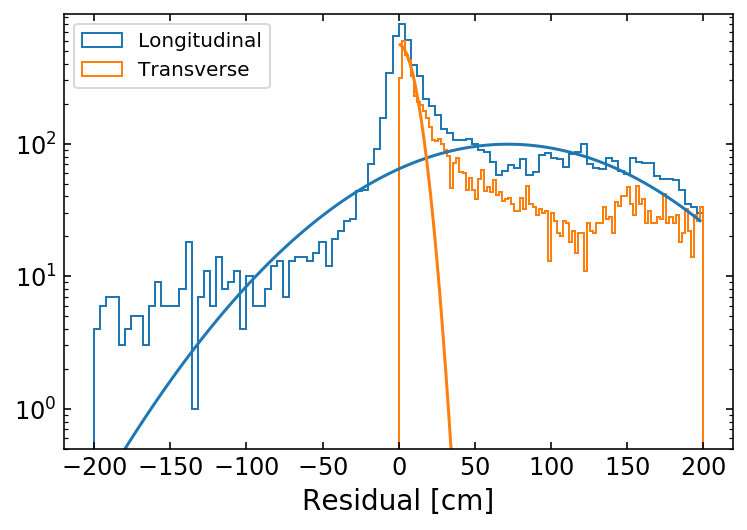

Text(0, 0.5, 'Transverse residual [cm]')

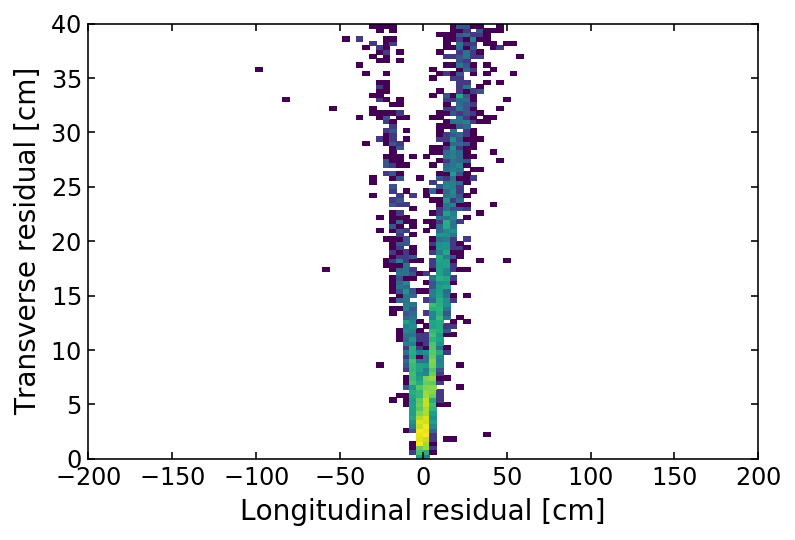

In [118]:
n,ibins,p=hist(residual_axial,range=(-200,200),histtype="step",label="Longitudinal");
n2,ibins2,p=hist(residual_radial,range=(0,200),histtype="step",label="Transverse");

bincenters=0.5*(ibins[1:]+ibins[:-1])
bincenters2=0.5*(ibins2[1:]+ibins2[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1
yerr2=np.sqrt(n2);yerr2[yerr2==0]=1

popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
print(popt[2],'[cm]')
plot(bincenters, util.Utils.Gauss(bincenters,*popt),color="C0")
popt,pcov = rt.fit_tg(bincenters2,n2,yerr=yerr2,function="gaus",set_constant=[[1,0]],initial_values=[max(n2),0,3],fit_range=(2,15),option="BQS")
print(popt[2],'[cm]')
plot(bincenters2, util.Utils.Gauss(bincenters2,*popt),color="C1")

yscale("log")
xlabel("Residual [cm]")
legend(fontsize=10,loc="upper left")
ylim(bottom=0.5,top=max([max(n),max(n2)])*1.2)
show()

hist2d(residual_axial, residual_radial,range=((-200,200),(0,40)),bins=(100,100),norm=LogNorm());
xlabel("Longitudinal residual [cm]")
ylabel("Transverse residual [cm]")

0.9263657730521073


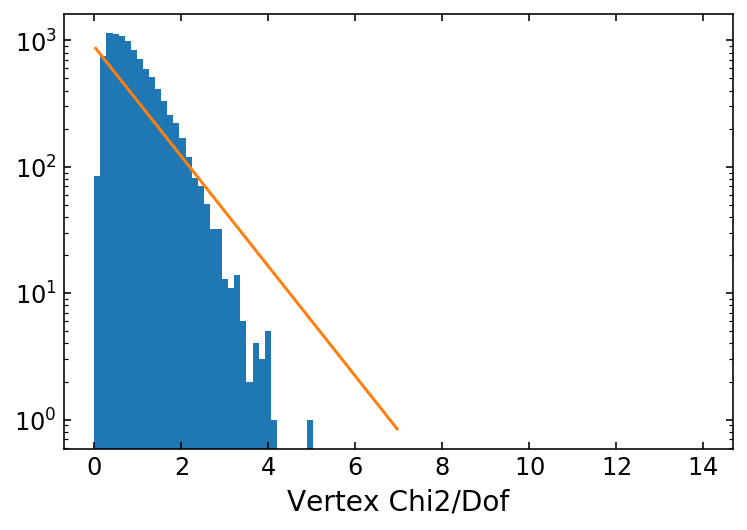

(0, 14)

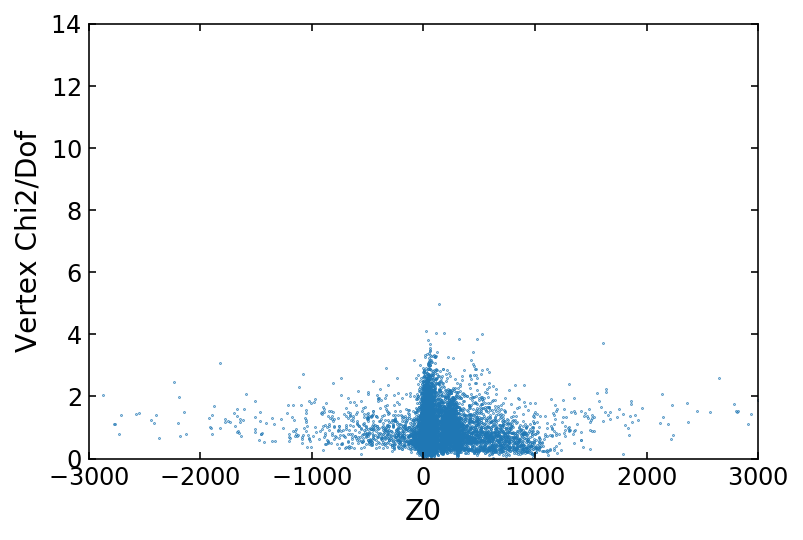

In [119]:
n,ibins,p = hist(Vertices_chi2,range=(0,14));
bincenters = util.Utils.center(ibins)

dof = 2
y = scipy.stats.chi2.pdf(bincenters,dof)
plot(bincenters/dof,y/y[dof]*n[1])
yscale("log")
xlabel("Vertex Chi2/Dof")
print(np.mean(Vertices_chi2))
show()

scatter(residual[:,2], Vertices_chi2,s=0.1);
xlabel("Z0")
ylabel("Vertex Chi2/Dof")
xlim(-3000,3000)
ylim(0,14)

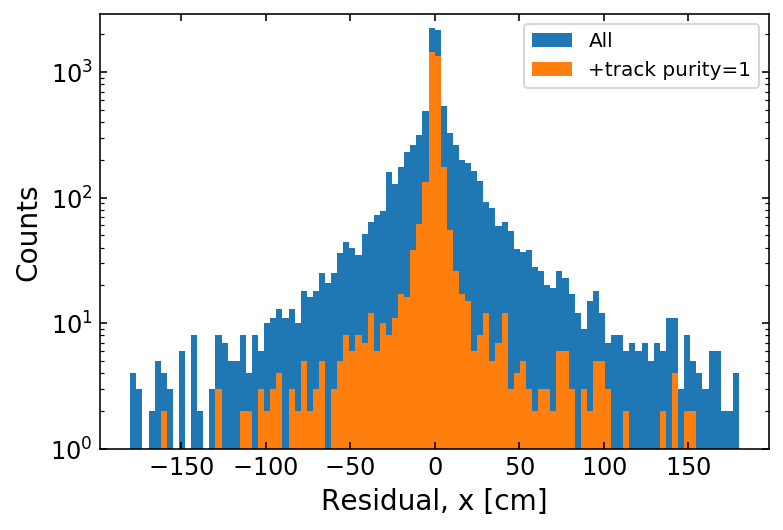

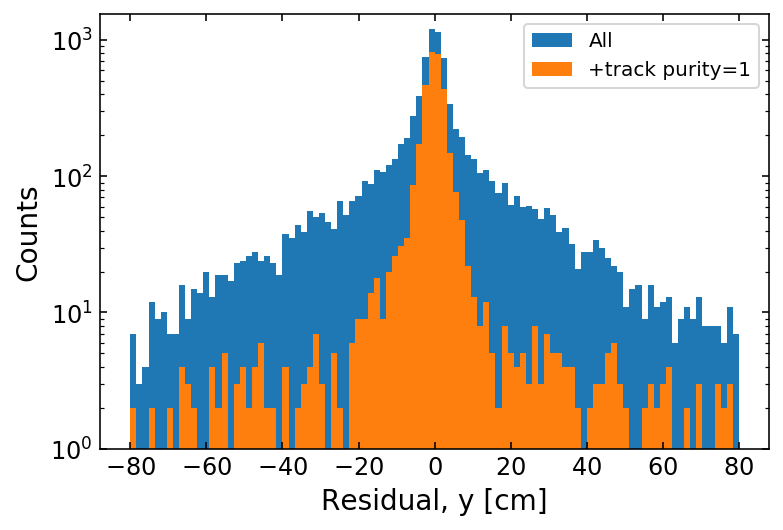

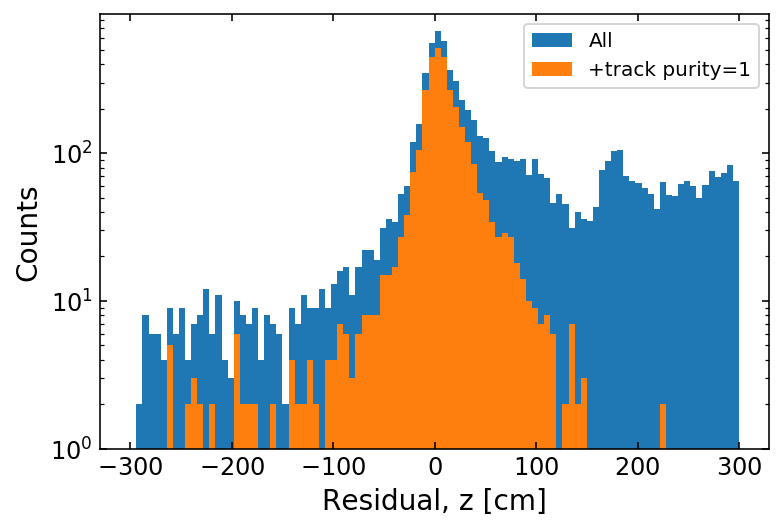

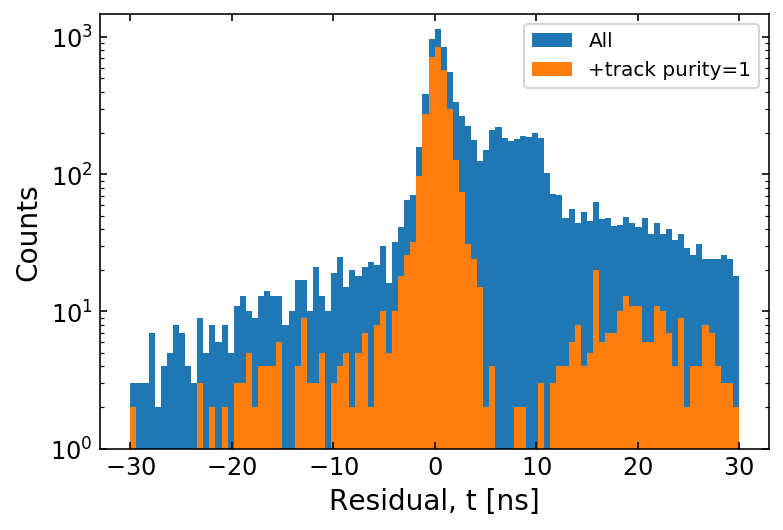

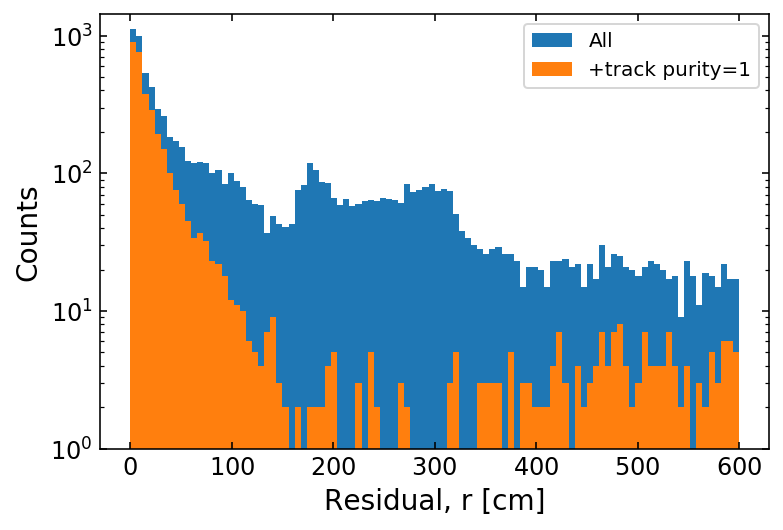

In [120]:
sigmas=[]
labels=["x [cm]", "y [cm]", "z [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-180,180],[-80,80],[-300,300],[-30,30],[0,600]]

for i in range(5):
    # if i<=2:
    #     continue
    n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i],label="All");
    n,ibins,_ = hist(residual[:,i][tracks_purity>0.99],range=plot_ranges[i],label="+track purity=1");
    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1
    

    
    # print("FWHM", fwhm)
    # print("SIGMA", popt[2])
    ylim(1, max(n0)*1.3)  
    xlabel("Residual, "+labels[i])
    ylabel("Counts")
    yscale("log")
    legend(fontsize=10)
    show()

In [121]:
mask_vertex_loose = (np.abs(residual[:,4])<150)
print("Efficiency LOOSE", sum(mask_vertex_loose)/len(mask))

joblib.dump({"residual":residual,"uncertainty":Vertices_err}, os.path.splitext(filename_recon)[0]+"_res.joblib")

Efficiency LOOSE 0.548


['../data/x2mumu_fake//stat_vertex_original_res.joblib']

---
### Run the following cell after obtaining data for all input files

In [125]:
Data=[joblib.load(os.path.splitext(filenames[i])[0]+"_res.joblib") for i in range(len(filenames))]

Efficiency Original: 0.45
Efficiency Now: 0.85


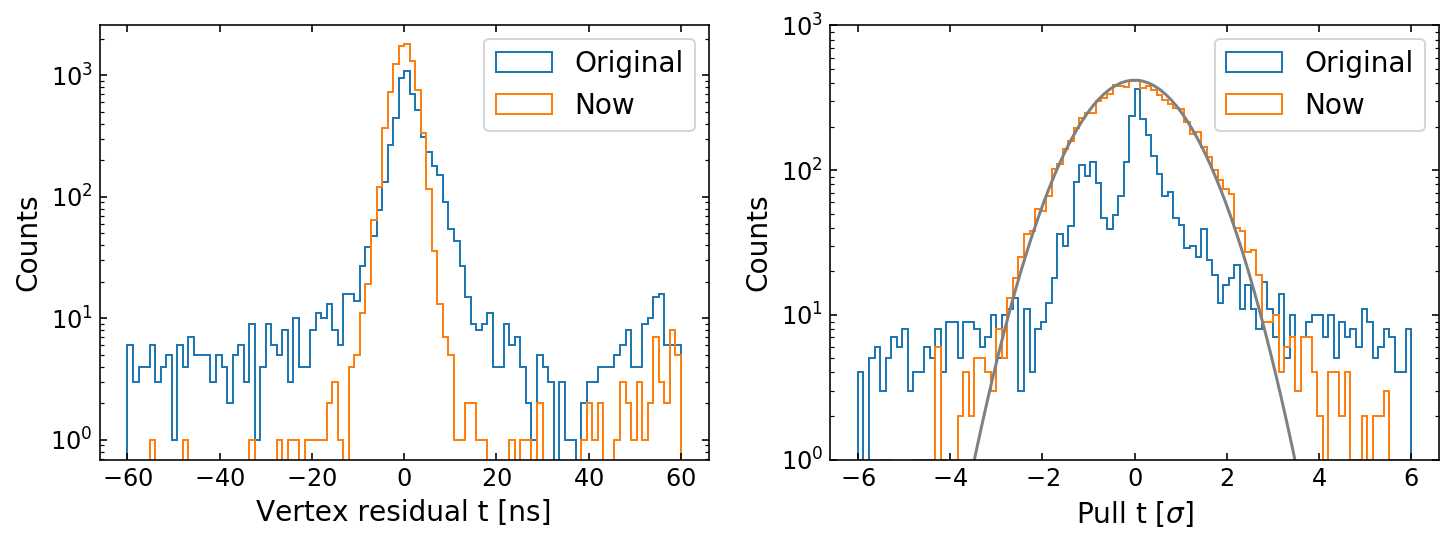

Efficiency Original: 0.45
Efficiency Now: 0.85


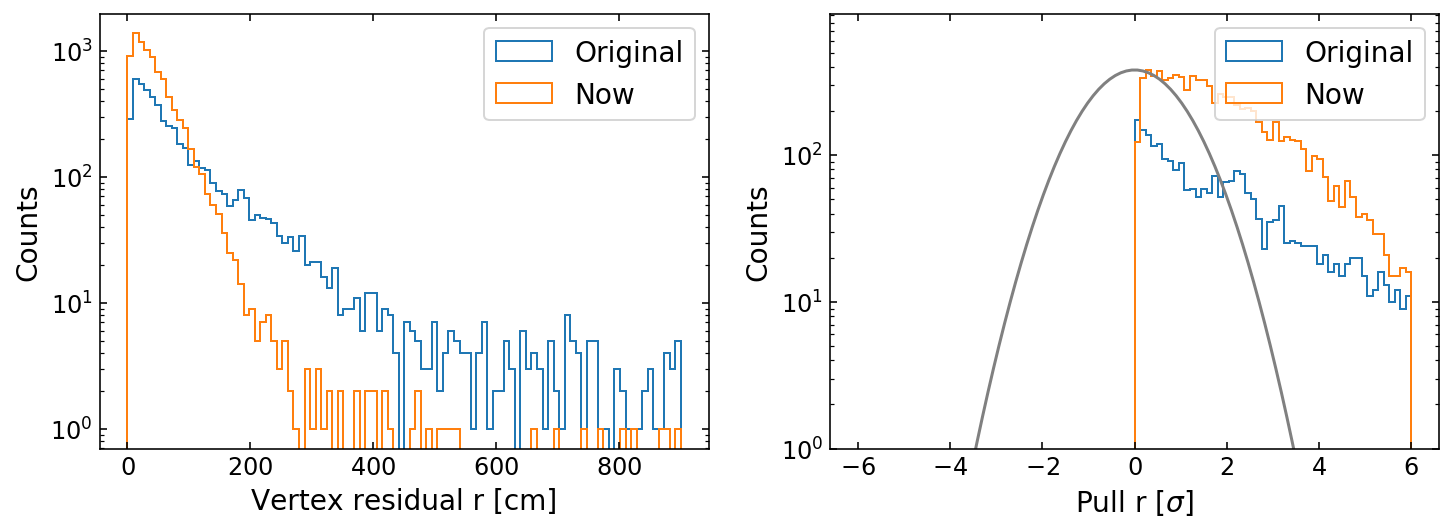

In [133]:
labels=["x [cm]", "y [cm]", "z [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-180,180],[-80,80],[-300,300],[-60,60],[0,900]]

plotlabels = ["Original", "Now"]

for i in [3,4]:
    fig, axs=subplots(1,2,figsize=(12,4))
    for idata in range(2):
        data=Data[idata]
        residual = data["residual"]
        unc = data["uncertainty"]
        
        sca(axs[0])
        n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i],label=plotlabels[idata],histtype="step");    
        print("Efficiency "+plotlabels[idata]+":", f"{sum((residual[:,4]<150)&(np.abs(residual[:,3])<10))/10000:.2f}")
        sca(axs[1])
        if i==3:
            pull = util.pull(residual[:,3],0,unc[:,3])
        elif i==4:
            unc_r = 1/residual[:,4]*np.sqrt(residual[:,1]**2*unc[:,1]**2 + residual[:,2]**2*unc[:,2]**2 + residual[:,0]**2*unc[:,0]**2 )
            pull = util.pull(residual[:,4],0,unc_r)
            
        n0,ibins,_ = hist(pull,range=[-6,6],label=plotlabels[idata],histtype="step"); 
        ibins=util.Utils.center(ibins)
        if idata==1:
            plot(ibins,util.Utils.Gauss(ibins,max(n0),0,1),color="grey")
        
    legend()
    
    sca(axs[0])
    xlabel("Vertex residual "+labels[i])
    ylabel("Counts")
    yscale("log")
    legend()
    sca(axs[1])
    xlabel("Pull "+labels[i].split(" ")[0]+r" [$\sigma$]")
    ylabel("Counts")
    yscale("log")  
    ylim(bottom=1)
    show()